In [32]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
#muon 
print 45.74/166.9

#tau
print 13.98/55.59

#electron
print 13.7/57.37

0.27405632115
0.25148407987
0.238800766951


In [3]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import os
import pickle
import itertools
from functions import *

import sys
# sys.path.append('/scratch9/mkron/software/DeepIceLearning/notebooks')
#import plot_functions_mk as pfmk
from fancy_plot import *
# from plot_conf import *
from icecube import NewNuFlux
if not os.path.exists('./out/'):
    os.makedirs('./out/')


In [67]:
def calc_weights(events):
    #for each type we have 50000*10000 simulated events
    atm_flux = NewNuFlux.makeFlux('honda2006')
    atm_flux.knee_reweighting_model = "gaisserH4a_elbert"
    prompt_flux = NewNuFlux.makeFlux('sarcevic_max')
    prompt_flux.knee_reweighting_model = "gaisserH4a_elbert"
    powerlaw = lambda energy: 0.91*1e-18*(energy/1e5)**(-2.19)
    sim_events = 50000*10000
    wdict = {0:3, 1:1, 2:3, 3:6, 4:30, 5:30, 6:30, 7:30, 8:30, 9:30}
    scaling = np.max([wdict[key] for key in wdict.keys()])
    test_ratio = 2./10.
    failed_jobs_scale = 1.2*4
    atm_weight = []
    prompt_weight = []
    astro_weight = []
    ev_count = []
    for ev in events:
        #correct_ow = ev['ow']/clen[np.abs(ev['firstParticle'])]/wdict[ev['ClassificationLabel']]
        correct_f = 1./test_ratio*(scaling/wdict[ev['ClassificationLabel']])*failed_jobs_scale
        atm_weight.append(ev['ow']/sim_events*correct_f*atm_flux.getFlux(ev['firstParticle'],
                          ev['energyFirstParticle'], -ev['dir_z'])*2.)
        prompt_weight.append(ev['ow']/sim_events*correct_f*prompt_flux.getFlux(ev['firstParticle'],
                             ev['energyFirstParticle'], -ev['dir_z'])*2.)
        astro_weight.append(ev['ow']/sim_events*correct_f*powerlaw(ev['energyFirstParticle']))
        ev_count.append(correct_f)
    return np.array(atm_weight), np.array(prompt_weight), np.array(astro_weight), np.array(ev_count)
        
    

###### Allocation of variables

In [68]:
# DATA_DIR = "/scratch9/tglauch/NN_out/run37/"
DATA_DIR = "../output/inc_res/"

predictions_mctrue = pickle.load(file(os.path.join(DATA_DIR, 'best_val_loss_pred.pickle')))
sample_len = len(predictions_mctrue['prediction'])

pred_label_1 = predictions_mctrue["prediction"] #list with probability for each class
true_label_1 = retag_classify_startTrack(predictions_mctrue["reco_vals"]
                                        ["ClassificationLabel"][:sample_len])
all_pred = np.argmax(pred_label_1, axis=1)
classes_1 = ("Cascade", "Track", "Double Bang", "StartingTrack")

# zenith_pred = np.arccos(-np.concatenate(predictions_mctrue["prediction"][1][:]))
# zenith_true = np.arccos(-predictions_mctrue['mc_truth']['dir_z_truth'][:sample_len])

# Number of hit DOMs
IC_hitDOMs = np.array(predictions_mctrue["IC_HitDOMs"][:sample_len])
DC_hitDOMs = np.array(predictions_mctrue["DC_HitDOMs"][:sample_len])
hitDOMs = IC_hitDOMs + DC_hitDOMs

energy=predictions_mctrue["reco_vals"]['energyFirstParticle'][:sample_len]
ptype = predictions_mctrue["reco_vals"]['firstParticle'][:sample_len]
azimuth_pred = np.arctan2(predictions_mctrue["reco_vals"]['dir_y'][:sample_len],
                         predictions_mctrue["reco_vals"]['dir_x'][:sample_len])
inelasticity=predictions_mctrue["reco_vals"]['inelasticity'][:sample_len]
tau_decay_length=predictions_mctrue["reco_vals"]['TauDecayLength'][:sample_len]

In [69]:
w1, w2, w3, ev_c = calc_weights(predictions_mctrue["reco_vals"][:sample_len])
tot_weight = w1 + w2 + w3

In [70]:
print 'Rate of atmo flux: {}'.format(np.sum(w1)*np.pi*1e7)
print 'Rate of prompt flux : {}'.format(np.sum(w2)*np.pi*1e7)
print 'Rate of astro flux : {}'.format(np.sum(w3[mask_bla])*np.pi*1e7)

Rate of atmo flux: 12988.0931488
Rate of prompt flux : 350.618568367
Rate of astro flux : 182.98163637


In [78]:
mask_bla = np.abs(ptype) == 16

In [83]:
print np.sum(ev_c[mask_bla])/(51*(50000-30))

0.986285889181


# Target 1 : Event Type

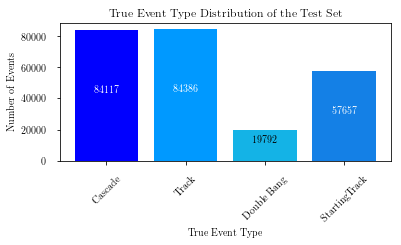

In [66]:
# composition of the Test Set according to the Event Tybe Lables
# Double check
barchart_classes(classes_1,
         [true_label_1.tolist().count(0), true_label_1.tolist().count(1), true_label_1.tolist().count(2),
          true_label_1.tolist().count(3)],
         'True Event Type Distribution of the Test Set', 'Number of Events', "True Event Type")

#### Acc 

In [42]:
#How many of all the predictions were right, independent of Event Type
print "General Acc for Event Typologies: {}".format(performence_target(pred_label_1 , true_label_1))

General Acc for Event Typologies: 76.5931658879


In [77]:
print 'Num Cascades {} / yr '.format(np.sum(tot_weight[true_label_1==0])*np.pi*1e7)
print 'Num Tracks {} / yr '.format(np.sum(tot_weight[true_label_1==1])*np.pi*1e7)
print 'Num Starting Events {} / yr '.format(np.sum(tot_weight[true_label_1==3])*np.pi*1e7)
print 'Num DB {} / yr '.format(np.sum(tot_weight[true_label_1==2])*np.pi*1e7)

Num Cascades 1412.88896086 / yr 
Num Tracks 8694.35270279 / yr 
Num Starting Events 3523.02881449 / yr 
Num DB 2.19334177018 / yr 


In [44]:
test = predictions_mctrue['reco_vals'][:sample_len]
mask = (true_label_1==3) & (all_pred==0) & (IC_hitDOMs > 600) 
    #(np.max(pred_label_1, axis=1)>0.90) & (test['TauDecayLength']>200)
test = test[mask] 
weight = tot_weight[mask]*np.pi*1e7
ind = np.argsort(weight)[::-1]

In [45]:
print len(test)

5


In [46]:
print test[ind]['firstParticle'][2]
print test[ind]['TauDecayLength'][2]
print test[ind]['dir_z'][2]
print test[ind]['RunID'][2]
print test[ind]['EventID'][2]

-16.0
2826.52978983
-0.56792361477
42073.0
73.0


### Confusion Plot

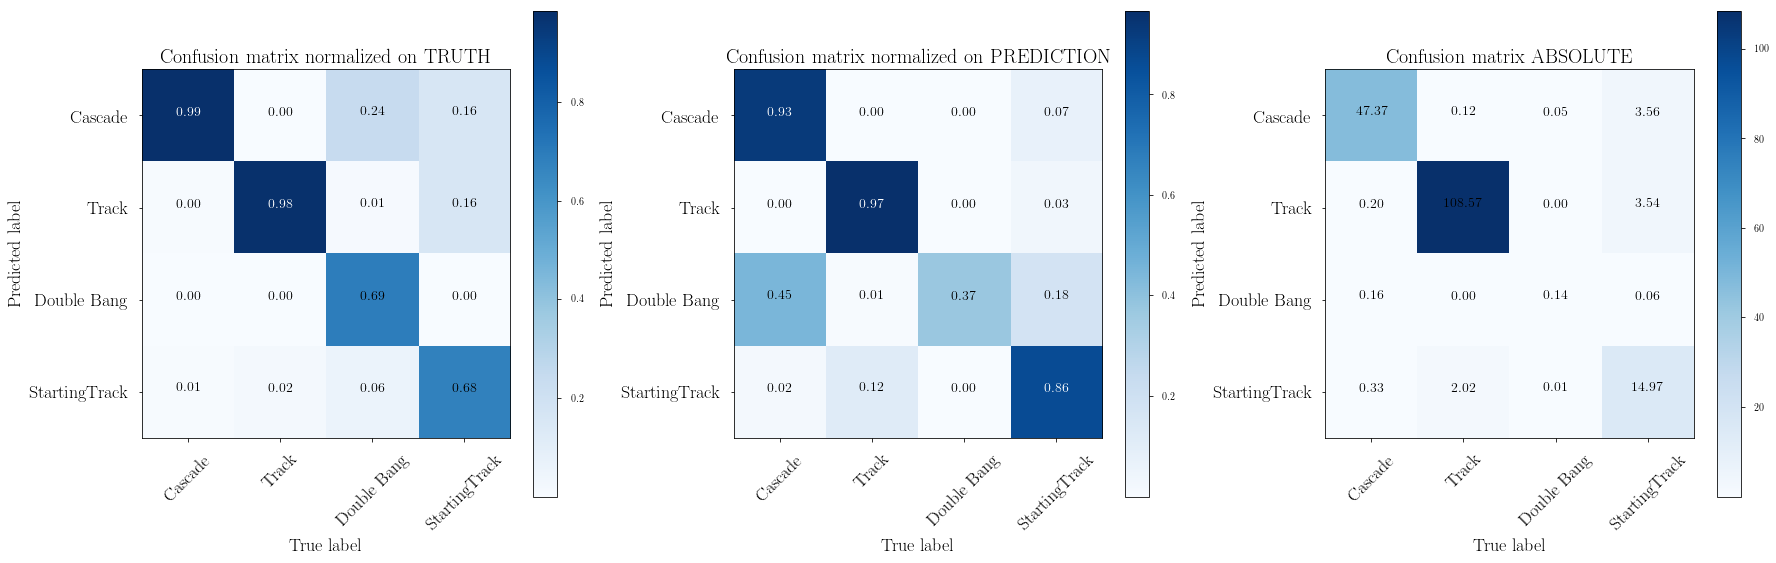

In [55]:
add_mask = (np.max(pred_label_1, axis=1)>0.79) 
if add_mask == []:
    add_mask = np.array([True]*len(all_pred))
fig = confusion_process(all_pred[add_mask],
                        true_label_1[add_mask],
                        classes_1,
                        weights=w3[add_mask]*np.pi*1e7)
plt.show()
fig.savefig('./out/confusion_matrix.png',dpi=300)

### Acc and corresponding statistic vs. Hit DOMS

In [18]:
acc_vs_hitDOMs_plot(pred_label_1[true_label_1 ==0], 0, np.log10(hitDOMs[true_label_1 == 0]), "Accuracy vs. number of hit DOMs for Cascades", 20)

TypeError: only integer scalar arrays can be converted to a scalar index

9.0


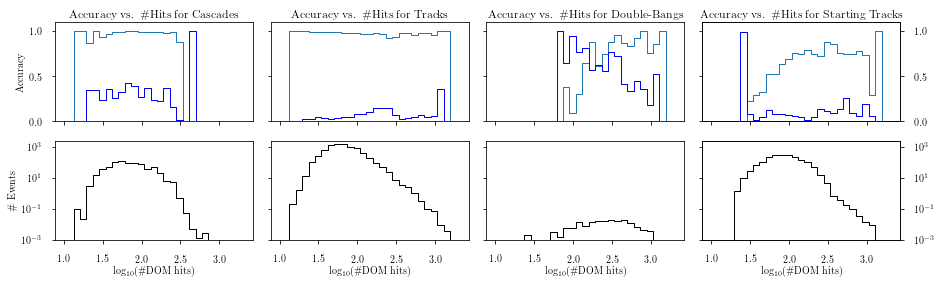

In [49]:
energy_dic = {'arr' : np.log10(energy), 'xbins' : np.linspace(1, 8, 30), 'title':'Energy',
              'xlabel': r'$\log_{10}$(E) [GeV]' , 'name' : 'energy'}
hits_dic = {'arr' : np.log10(IC_hitDOMs), 'xbins' : np.linspace(1, 3.4, 30), 'title': '\#Hits',
            'xlabel': r'$\log_{10}$(\#DOM hits)', 'name': 'hits'}


flux_weight = True
which = hits_dic # <--------Set this one
add_mask = np.max(pred_label_1, axis=1)>0.8 #np.max(pred_label_1, axis=1)>0.8 #np.max(pred_label_1, axis=1)>0.7 #inelasticity <0.2 #[]#np.max(pred_label_1, axis=1)>0.55
add_str = 'all_'

if flux_weight:
    atm_w, prompt_w, astro_w = calc_weights(predictions_mctrue["reco_vals"][:sample_len])
    tot_weight = (atm_w + prompt_w + astro_w)*np.pi*1e7
    add_str += 'flux_weight_'
else:
    tot_weight=np.ones(len(all_pred))
    add_str += 'no_weight_'
    

add_str += which['name']+'_'

if add_mask == []:
    add_mask = np.array([True]*len(tot_weight))

fig1 = plt.figure(figsize=(2*1.618*4.07, 4.07))

ax1 = plt.subplot2grid((2, 4), (0, 0))
ax1 = acc_vs_quantity_plot(all_pred, true_label_1, 0,
                         which['arr'],
                         r"Accuracy vs. {} for Cascades".format(which['title']),
                         which['xbins'], ax1, weights=tot_weight, add_mask = add_mask)
ax1.set_xticklabels([])
ax1.set_ylabel('Accuracy')

ax2 = plt.subplot2grid((2, 4), (0, 1))
ax2 = acc_vs_quantity_plot(all_pred, true_label_1, 1,
                         which['arr'],
                         r"Accuracy vs. {} for Tracks".format(which['title']),
                         which['xbins'], ax2, weights=tot_weight, add_mask = add_mask)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax3 = plt.subplot2grid((2, 4), (0, 2))
ax3 = acc_vs_quantity_plot(all_pred, true_label_1, 2,
                         which['arr'], r"Accuracy vs. {} for Double-Bangs".format(which['title']),
                         which['xbins'], ax3, weights=tot_weight, add_mask = add_mask)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

ax31 = plt.subplot2grid((2, 4), (0, 3))
ax31 = acc_vs_quantity_plot(all_pred, true_label_1, 3,
                          which['arr'], r"Accuracy vs. {} for Starting Tracks".format(which['title']),
                          which['xbins'], ax31,weights=tot_weight, add_mask = add_mask)
ax31.set_xticklabels([])
ax31.set_yticklabels([])
ax31_2 = ax31.twinx()
ax31_2.set_ylim(ax31.get_ylim())

ax4 = plt.subplot2grid((2, 4), (1, 0))
max_vals = []
mask = (true_label_1 == 0) & add_mask
valsAll = np.histogram(which['arr'][mask], bins=which['xbins'],
                       weights=tot_weight[mask])[0]
max_vals.append(np.max(valsAll))
ax4.semilogy(which['xbins'][:-1], valsAll, drawstyle = 'steps-mid', color='k')
ax4.set_xlabel(which['xlabel'])
ax4.set_ylabel(r'\# Events')

ax5 = plt.subplot2grid((2, 4), (1, 1))
mask = (true_label_1 == 1) & add_mask
valsAll = np.histogram(which['arr'][mask], bins=which['xbins'],
                      weights=tot_weight[mask])[0]
ax5.semilogy(which['xbins'][:-1], valsAll, drawstyle = 'steps-mid', color='k')
ax5.set_xlabel(which['xlabel'])
max_vals.append(np.max(valsAll))
ax5.set_yticklabels([])

ax6 = plt.subplot2grid((2, 4), (1, 2))
mask = (true_label_1 == 2) & add_mask
valsAll = np.histogram(which['arr'][mask], bins=which['xbins'],
                      weights=tot_weight[mask])[0]
ax6.semilogy(which['xbins'][:-1], valsAll, drawstyle = 'steps-mid', color='k')
ax6.set_xlabel(which['xlabel'])
ax6.set_yticklabels([])
max_vals.append(np.max(valsAll))

ax61 = plt.subplot2grid((2, 4), (1, 3))
mask = (true_label_1 == 3) & add_mask
valsAll = np.histogram(which['arr'][mask], bins=which['xbins'],
                      weights=tot_weight[mask])[0]
ax61.semilogy(which['xbins'][:-1], valsAll, drawstyle = 'steps-mid', color='k')
ax61.set_xlabel(which['xlabel'])
ax61.set_yticklabels([])
max_vals.append(np.max(valsAll))

ax4.set_ylim(0.001, 1.5*np.max(max_vals))
ax5.set_ylim(0.001, 1.5*np.max(max_vals))
ax6.set_ylim(0.001, 1.5*np.max(max_vals))
ax61.set_ylim(0.001, 1.5*np.max(max_vals))
ax61_2 = ax61.twinx()
ax61_2.set_ylim(ax61.get_ylim())
ax61_2.set_yscale('log')
plt.tight_layout()
fig1.subplots_adjust(wspace=0.0, hspace=0.0)
fig1.savefig('./out/accuracy.pdf'.format(add_str))
plt.show()

## Target 2: Starting

In [13]:
summary_plot_binary_target(np.argmax(pred_label_2, axis=1), true_label_2, ("Starting", "Through-going"), hitDOMs, 30)

NameError: name 'pred_label_2' is not defined

## Target 3: Zenith Regression

Text(0,0.5,'counts')

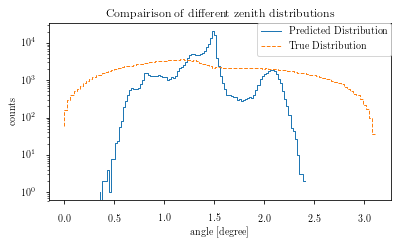

In [32]:
fig, ax1 = newfig(0.9)
vals_pred, bins = np.histogram(zenith_pred, bins=100)
ax1.semilogy(bins[:-1], vals_pred, drawstyle='steps-pre', label="Predicted Distribution")
vals_true, bins = np.histogram(zenith_true, bins=100)
ax1.semilogy(bins[:-1], vals_true, drawstyle='steps-pre', label="True Distribution", linestyle = '--')
ax1.legend(loc ='best', ncol=1, borderaxespad=0.)
ax1.set_title(r"Compairison of different zenith distributions")
ax1.set_xlabel(r'angle [degree]')
ax1.set_ylabel(r'counts')

Text(0,0.5,'counts')

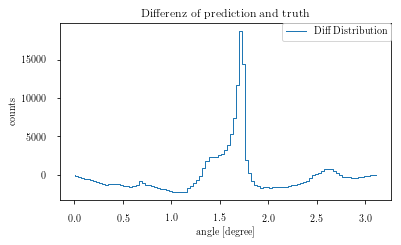

In [33]:
fig, ax1 = newfig(0.9)
ax1.plot(bins[:-1], vals_pred - vals_true, drawstyle='steps-pre', label="Diff Distribution")
ax1.legend(ncol=1, borderaxespad=0., loc ='best') #bbox_to_anchor=(0.975 , 0.3),
ax1.set_title(r"Differenz of prediction and truth")
ax1.set_xlabel(r'angle [degree]')
ax1.set_ylabel(r'counts')

## Extremeness of Predictions
##### Probabilitys of Predictions

In [76]:
def prob(pred, log, title):
    prob_cascade = []
    prob_track = []
    prob_db = []
    prob_sT = []
    for i in xrange(len(pred)):
        prob_cascade.append(pred[i][0])
        prob_track.append(pred[i][1])
        prob_db.append(pred[i][2])
        prob_sT.append(pred[i][3])

    bins = np.linspace(0, 1, 100)
    valsCascade = np.histogram(prob_cascade, bins=bins)[0]
    valsTrack = np.histogram(prob_track, bins=bins)[0]
    valsDB = np.histogram(prob_db, bins=bins)[0]
    valssT = np.histogram(prob_sT, bins=bins)[0]
    
    if log:
        plt.semilogy(bins[:-1], valsCascade, drawstyle = 'steps-mid', label="Cascade")
        plt.semilogy(bins[:-1], valsTrack, drawstyle = 'steps-mid', label="Track")
        plt.semilogy(bins[:-1], valsDB, drawstyle = 'steps-mid', label="Double Bang")
        plt.semilogy(bins[:-1], valssT, drawstyle = 'steps-mid', label="Starting Track")
    else:
        plt.plot(bins[:-1], valsCascade, drawstyle = 'steps-mid', label="Cascade")
        plt.plot(bins[:-1], valsTrack, drawstyle = 'steps-mid', label="Track")
        plt.plot(bins[:-1], valsDB, drawstyle = 'steps-mid', label="Double Bang")
        plt.plot(bins[:-1], valssT, drawstyle = 'steps-mid', label="Starting Track")
    plt.legend(loc='best')

    plt.title(title)
    plt.ylabel("Counts")
    plt.xlabel("Probability")

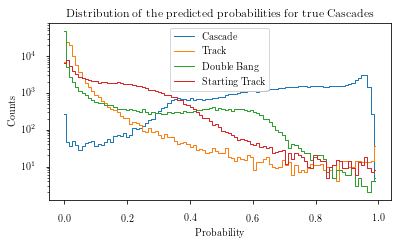

In [77]:
prob(pred_label_1[true_label_1 == 0],
     log=True,
     title="Distribution of the predicted probabilities for true Cascades")

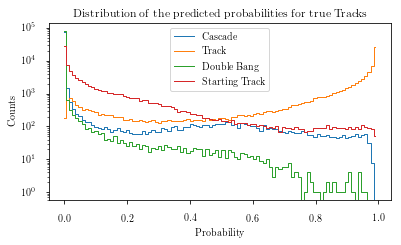

In [78]:
prob(pred_label_1[true_label_1 == 1], log=True, title="Distribution of the predicted probabilities for true Tracks")

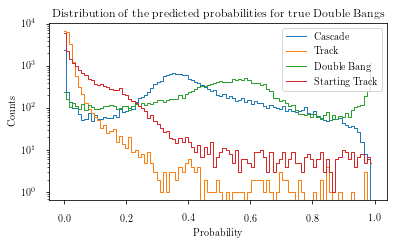

In [79]:
prob(pred_label_1[true_label_1 == 2], log=True, title="Distribution of the predicted probabilities for true Double Bangs")

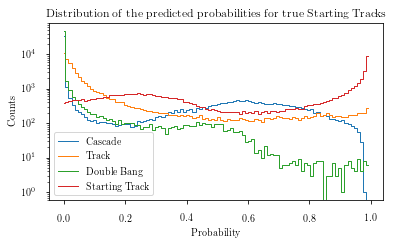

In [80]:
prob(pred_label_1[true_label_1 == 3], log=True, title="Distribution of the predicted probabilities for true Starting Tracks")

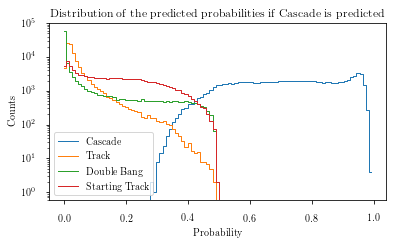

In [81]:
prob(pred_label_1[all_pred == 0], log=True, title="Distribution of the predicted probabilities if Cascade is predicted")

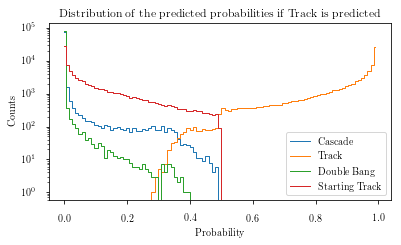

In [82]:
prob(pred_label_1[all_pred == 1], log=True, title="Distribution of the predicted probabilities if Track is predicted")

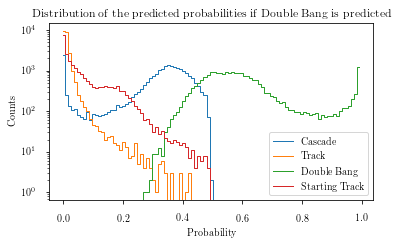

In [83]:
prob(pred_label_1[all_pred == 2], log=True, title="Distribution of the predicted probabilities if Double Bang is predicted")

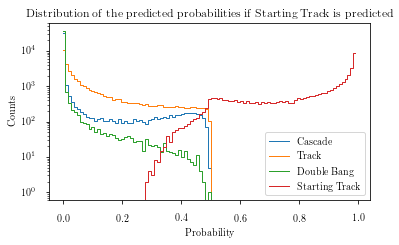

In [84]:
prob(pred_label_1[all_pred == 3], log=True, title="Distribution of the predicted probabilities if Starting Track is predicted")

In [27]:
def prob_acc(type_ind, weights=[]):
    preds = pred_label_1[all_pred == type_ind]
    truth = true_label_1[all_pred == type_ind]
    if weights == []:
        weights = np.ones(len(preds))
    else:
        weights = weights[all_pred == type_ind]
    prob = []
    for pred in preds:
        prob.append(pred[type_ind])
    prob = np.array(prob)

    x = np.linspace(0,1,100)
    val = []
    for xvalue in x:
        divider = np.sum(weights[prob > xvalue])
        if divider == 0:
            acc_i = np.max(val)
        else:
            acc_i = np.sum(weights[(prob > xvalue) & (truth==type_ind)])/divider
        val.append(acc_i)
    return val

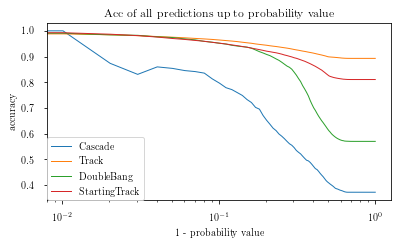

In [28]:
val_Cascade = prob_acc(0, weights=tot_weight)
val_Track = prob_acc(1)
val_DB = prob_acc(2)
val_StartTrack = prob_acc(3)
x = 1-np.linspace(0,1,100)

fig, ax1 = newfig(0.9)

ax1.plot(x, val_Cascade, label="Cascade")
ax1.plot(x, val_Track, label="Track")
ax1.plot(x, val_DB, label="DoubleBang")
ax1.plot(x, val_StartTrack, label="StartingTrack")
ax1.legend(loc ='best', ncol=1, borderaxespad=0.)
ax1.set_title(r"Acc of all predictions up to probability value")
ax1.set_xlabel(r'1 - probability value')
ax1.set_xscale('log')
ax1.set_ylabel(r'accuracy')
fig.savefig('./out/accuracy_prob.pdf')

### Cross-Dependencies of Classes

In [21]:
# if StartingTag is truely NON-STARTING, the Event classes are distributed as follow
print true_label_1[true_label_2 == 1].tolist().count(0)
print true_label_1[true_label_2 == 1].tolist().count(1)
print true_label_1[true_label_2 == 1].tolist().count(2)
print true_label_1[true_label_2 == 1].tolist().count(3)

NameError: name 'true_label_2' is not defined

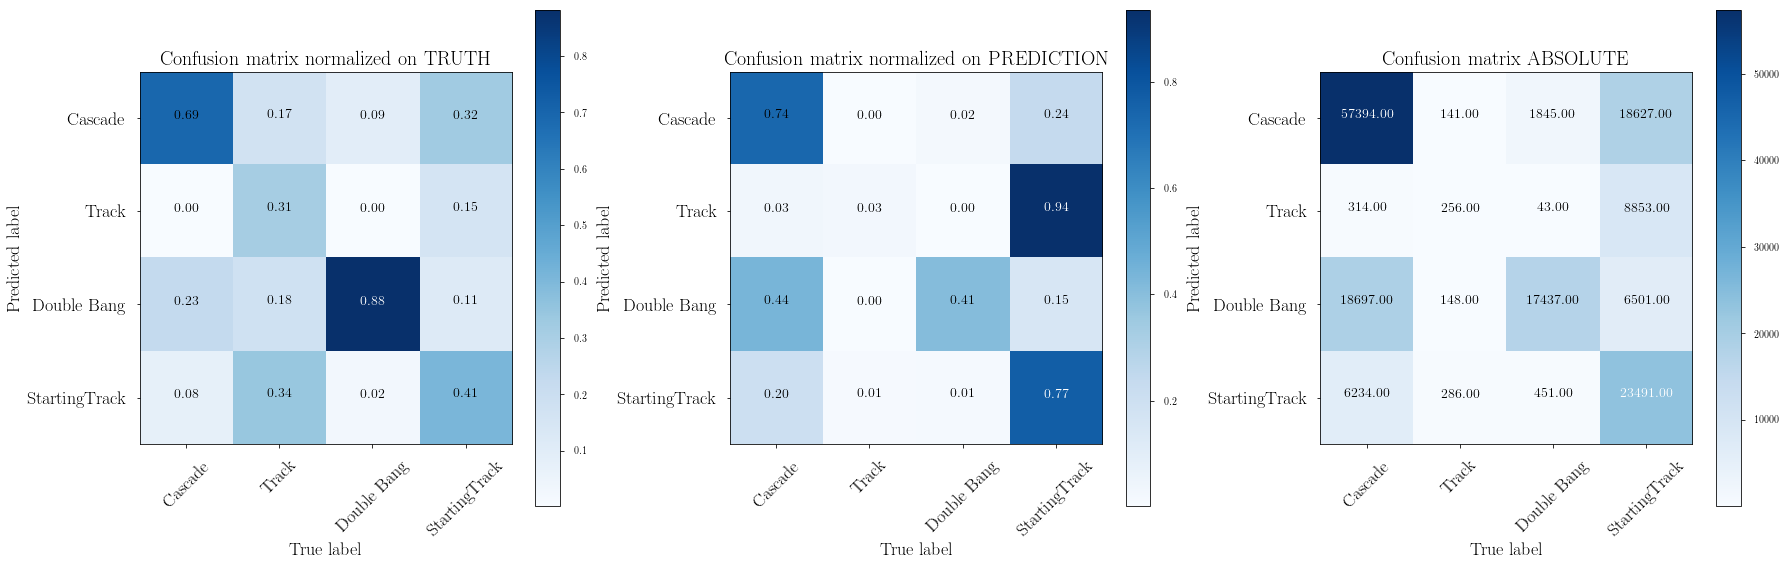

In [158]:
# Confusion martixes for only truly starting events
classes = ("Cascade", "Track", "Double Bang", "StartingTrack")

confusion_process(all_pred[true_label_2 == 0], true_label_1[true_label_2 == 0], classes)


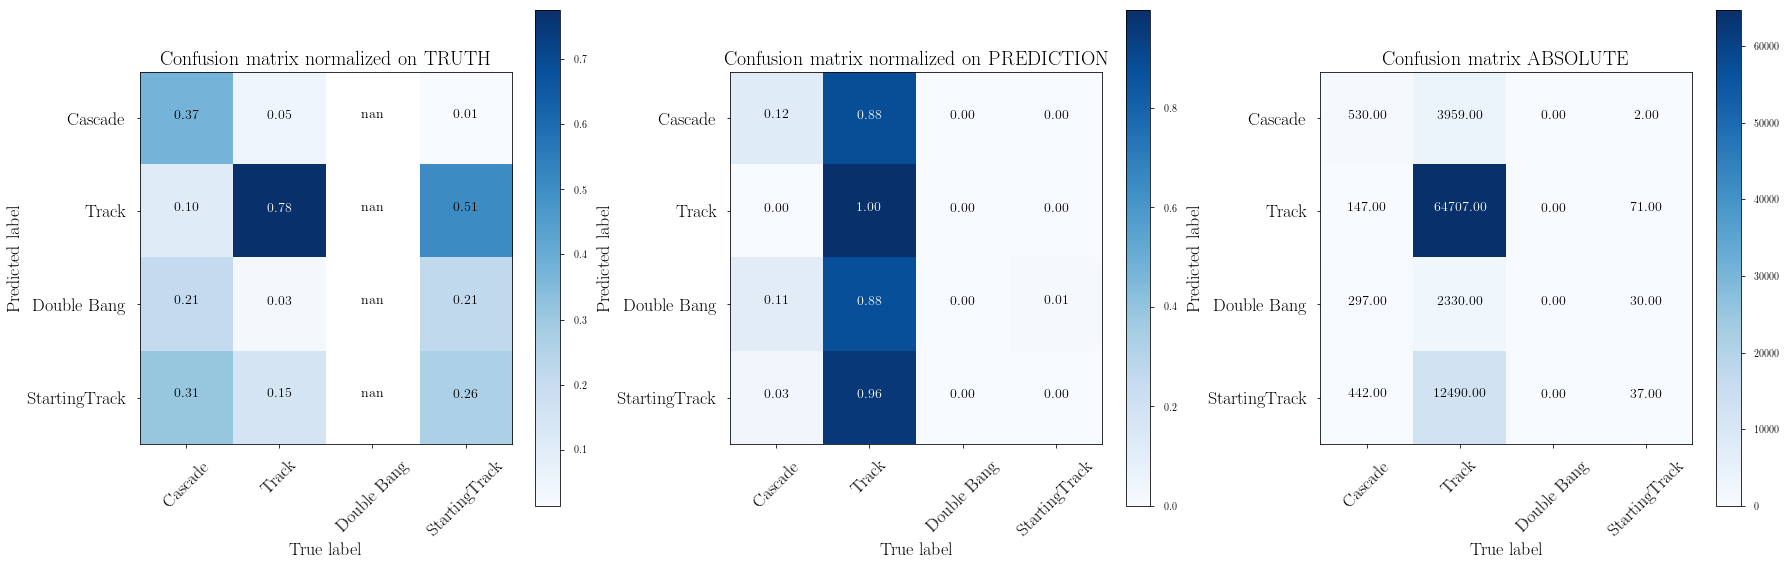

In [159]:
# Confusion martixes for only truly trough-going events
confusion_process(all_pred[true_label_2 == 1], true_label_1[true_label_2 == 1], classes)


### Inelasticity Plot

In [10]:
type_dict = {0:'Cascade', 1:'Track', 2: 'DB', 3:'Starting Track'}
# Percentage of the Events classified as one Type for all Classes given Events of one true Type, binned in an x-quantity

def perc_class_against_x(which_type, x_quantity, title, x_axis, x_min, x_max, binnumber, norm_on='true'):
        
    # percentage of true Events of given Event Type, in a given range
    if norm_on == 'true':
        ev_type = all_pred[true_label_1 == which_type] # predicted probabilities only for true EventType Events
        x_quantity = x_quantity[true_label_1 == which_type] # x only for true EventType Events
    elif norm_on == 'pred':
        ev_type = all_pred[(true_label_1 == which_type) & (all_pred!=which_type)]
        x_quantity = x_quantity[(true_label_1 == which_type) & (all_pred!=which_type)]

    fig, ax1 = newfig(0.9)
    bins = np.linspace(x_min, x_max, binnumber)
    valsAll = np.histogram(x_quantity, bins=bins)[0]

    for ev_type_key in type_dict.keys():
        ax1.plot(bins[:-1],
                1.0*np.histogram(x_quantity[ev_type == ev_type_key], bins=bins)[0]/valsAll,
                drawstyle = 'steps-mid', label=type_dict[ev_type_key])

    ax1.legend(loc='best', ncol=4)
    ax1.set_title(title)
    ax1.set_xlabel(x_axis)
    ax1.set_ylabel(r'Percentage of Events')
    return fig

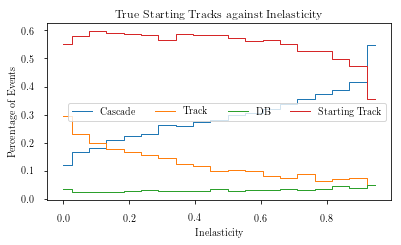

In [47]:
fig = perc_class_against_x(3, inelasticity, 
                           "True Starting Tracks against Inelasticity",
                           'Inelasticity',0, 1, 20)
#fig.savefig('./out/inelasticity.pdf')

### DB acc vs. Tau decay length

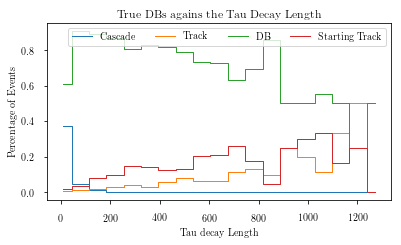

In [48]:
fig = perc_class_against_x(2,tau_decay_length, 
                           "True DBs agains the Tau Decay Length",
                           'Tau decay Length',
                            np.min(tau_decay_length[true_label_1 == 2]),
                            np.max(tau_decay_length[true_label_1 == 2]), 20)

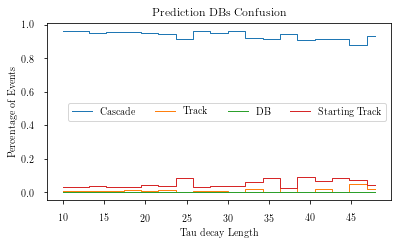

In [12]:
## What is predicted if the event is true tau but not classified as one

fig = perc_class_against_x(2, tau_decay_length, 
                           "Prediction DBs Confusion",
                           'Tau decay Length',
                            np.min(tau_decay_length[true_label_1 == 2]),
                            50, 20, norm_on='pred')
fig.savefig('db_confusion.pdf')

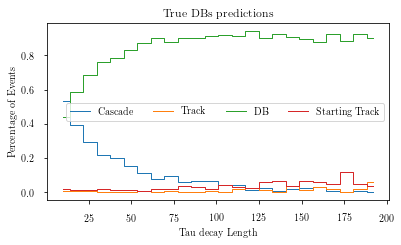

In [54]:
fig = perc_class_against_x(2, tau_decay_length, 
                           "True DBs predictions",
                           'Tau decay Length',
                            np.min(tau_decay_length[true_label_1 == 2]),
                            200, 25)

# Loos PLot

IndexError: index 14 is out of bounds for axis 0 with size 9

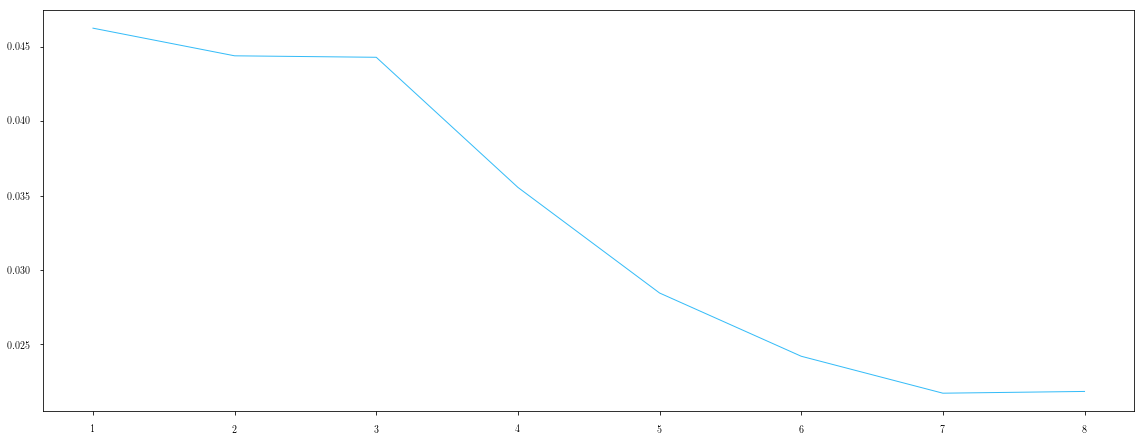

In [156]:
fig = plt.figure(figsize=(16,18))

ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
x = np.linspace(1, len(epochs_acc_loss[0]), num=len(epochs_acc_loss[0]), endpoint=True)
ax0.plot(x, epochs_acc_loss[7], color="#35bcf8", label="total loss of the training set")
ax0.plot(x, epochs_acc_loss[14], color='#af27cd', label="total loss of the validation set")
ax0.legend(bbox_to_anchor=(0.79, 0.97), loc=2, borderaxespad=0.)
ax0.set_ylabel('loss & percentage')
ax0.set_xlabel("epochs")
ax0.set_title("Total Loss")

ax1 = plt.subplot2grid((3, 2), (1, 0), colspan=1)
ax1 = acc_loss_plot(acc_train_1, loss_train_1, acc_val_1, loss_val_1, "Target1: Event Type")

ax2 = plt.subplot2grid((3, 2), (1, 1), colspan=1)
ax2 = acc_loss_plot(acc_train_2, loss_train_2, acc_val_2, loss_val_2, "Target2: Starting")

ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=1)
ax3 = acc_loss_plot(acc_train_3, loss_train_3, acc_val_3, loss_val_3, "Target3: UpDown")

In [57]:
# Identify the overall best run  
sum_acc_val = acc_val_1 + acc_val_2 + acc_val_3

print "ACC for the single Targets of the overall best epoch"
print "Acc on Validation Set of Target 1 Event Type : {}%".format(round(np.max(acc_val_1[np.argmax(sum_acc_val)])*100 ,2))
print "Acc on Validation Set of Target 2 Starting   : {}%".format(round(np.max(acc_val_2[np.argmax(sum_acc_val)])*100 ,2))
print "Acc on Validation Set of Target 3 UpDown: {}%".format(round(np.max(acc_val_3[np.argmax(sum_acc_val)])*100 ,2))

print np.argmax(sum_acc_val)

NameError: name 'acc_val_1' is not defined

In [58]:
print "Max ACC of the single Targets, not neccesaryly in the same epoch"
print "Acc on Validation Set of Target 1 Event Type : {}%".format(round(np.max(acc_val_1)*100 ,2))
print "Acc on Validation Set of Target 2 Starting   : {}%".format(round(np.max(acc_val_2)*100 ,2))
print "Acc on Validation Set of Target 3 UpDown: {}%".format(round(np.max(acc_val_3)*100 ,2))

Max ACC of the single Targets, not neccesaryly in the same epoch


NameError: name 'acc_val_1' is not defined

No handlers could be found for logger "matplotlib.legend"


Text(0,0.5,u'accuracy')

Error in callback <function post_execute at 0x7f6573642668> (for post_execute):


RuntimeError: LaTeX was not able to process the following string:
'log_10(E) [GeV]'

Here is the full report generated by LaTeX:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode
(./8bf6c07f33b2c935ed2ebfbff26f666a.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, ru
ssian, ukrainian, bulgarian, loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 8bf6c07f33b2c935ed2ebfbff26f666a.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ...tsize{11.000000}{13.750000}{\rmfamily log_
                                                  10(E) [GeV]}
! Extra }, or forgotten $.
l.12 ...000}{13.750000}{\rmfamily log_10(E) [GeV]}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./8bf6c07f33b2c935ed2ebfbff26f666a.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 8bf6c07f33b2c935ed2ebfbff26f666a.dvi (1 page, 360 bytes).
Transcript written on 8bf6c07f33b2c935ed2ebfbff26f666a.log.
 



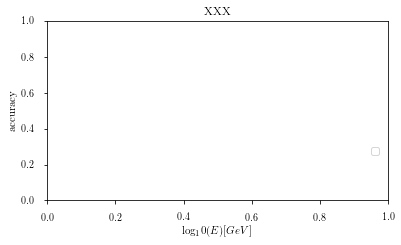

In [59]:
#THEO PLOT STYLE
fig, ax1 = newfig(0.9)

x = np.linspace(1, len(epochs_acc_loss[0]), num=len(epochs_acc_loss[0]), endpoint=True)

ax1.legend(bbox_to_anchor=(0.975 , 0.3), ncol=2, borderaxespad=0.) #loc ='best'
ax1.set_title(r"XXX")#, fontsize=18)
ax1.set_xlabel(r'log_10(E) [GeV]')#, fontsize=16)
ax1.set_ylabel(r'accuracy')#, fontsize=16)
#ax1.set_ylim(-0.2, 1.05)

In [18]:
data=pickle.load(file('../data.pickle'))

In [19]:
mjd=data['reco_vals']['MJD']
ind = np.argsort(mjd)
mjd = mjd[ind]
pred=np.argmax(data['prediction'][ind], axis=1)

In [24]:
data['prediction'][ind][12]

array([ 0.03202622,  0.05636567,  0.01581641,  0.89579177], dtype=float32)

In [22]:
for i in range(len(mjd)):
    print mjd[i], pred[i], data['reco_vals'][ind][i]

56817.3895772 2 ( 56817.38957718,  124852.,  18750800.,  0.,  1.,  0.)
56830.5266506 0 ( 56830.52665061,  124927.,  17485033.,  0.,  1.,  1.)
56859.7588218 3 ( 56859.75882183,  125071.,  31397276.,  0.,  1.,  1.)
56922.5853012 0 ( 56922.58530125,  125335.,  34854587.,  0.,  1.,  1.)
56931.9311034 0 ( 56931.93110344,  125365.,  30022811.,  0.,  1.,  1.)
56970.2073615 3 ( 56970.20736146,  125541.,  33181530.,  0.,  1.,  1.)
56987.7721852 3 ( 56987.77218517,  125627.,  57329677.,  0.,  1.,  1.)
57000.1431061 3 ( 57000.14310609,  125700.,  41534045.,  0.,  1.,  1.)
57036.7437753 0 ( 57036.74377525,  125914.,  75630389.,  0.,  1.,  1.)
57051.6637848 0 ( 57051.66378481,  125975.,  22186251.,  0.,  1.,  1.)
57053.1272661 0 ( 57053.12726611,  125979.,  54250116.,  0.,  1.,  1.)
57079.9653212 2 ( 57079.96532124,  126090.,  33142246.,  0.,  1.,  1.)
57081.535264 3 ( 57081.53526397,  126099.,  12931336.,  0.,  1.,  1.)
57133.7900745 3 ( 57133.79007445,  126281.,  61439434.,  0.,  1.,  1.)
57134.3

In [98]:
from icecube import dataio

In [108]:
f = dataio.I3File('./../../Software/testdata/l2_00000996.i3.bz2')

In [115]:
N=0
f = dataio.I3File('./../../Software/testdata/l2_00000996.i3.bz2')
powerlaw = lambda energy: 0.91*1e-18*(energy/1e5)**(-2.19)
while f.more():
    phy_f = f.pop_physics()
    w_dict = phy_f['I3MCWeightDict']
    r = powerlaw(w_dict["PrimaryNeutrinoEnergy"]) * w_dict["OneWeight"] / (w_dict['NEvents'])
    N+= r

In [117]:
print N*np.pi*1e7

90.1049492967
